# Iteratively Reweighted Least Squares

In [1]:
using LinearAlgebra

In [67]:
function wlsq(A, y, w) 
    W = Diagonal(sqrt.(w))
    Aw = W * A 
    yw = W * y 
    return qr(Aw) \ yw
end 

function irlsq_max(A, y; tol=1e-5, maxnit = 100, γ = 1.0, γmin = 1e-6)
    M, N = size(A)
    @assert M == length(y)
    wold = w = ones(M) / M
    res = 1e300
    x = zeros(N)
    for nit = 1:maxnit 
        x = wlsq(A, y, w)
        resnew = norm(y - A * x, Inf)
        @show resnew, γ, extrema(w)
        if resnew >= res 
            γ /= 2
            if γ < γmin
                break
            end
            w = wold
        else 
            wold = w
            res = resnew
        end
 
        wnew = w .* (abs.(y - A * x).^γ .+ 1e-15)
        wnew /= sum(wnew)
        w = wnew 
        
#         if norm(wnew - w, Inf) < tol
#             @info("irlsq_max converged")
#             return x 
#         end  
    end
#     @error("irlsq_max terminated without converging")
    return x, w, res 
end

irlsq_max (generic function with 1 method)

In [78]:
A = rand(20, 10)
y = rand(20)
x, w, res = irlsq_max(A, y)
;

(resnew, γ, extrema(w)) = (0.41559769055274143, 1.0, (0.05, 0.05))
(resnew, γ, extrema(w)) = (0.3330540158994536, 1.0, (0.0032904152118839506, 0.1490602110440618))
(resnew, γ, extrema(w)) = (0.30144384699270077, 1.0, (0.0001836126495054335, 0.17203440516774804))
(resnew, γ, extrema(w)) = (0.29271416171235776, 1.0, (1.509750578540208e-5, 0.18648901368133022))
(resnew, γ, extrema(w)) = (0.3052741385750506, 1.0, (3.288098448508957e-6, 0.19451768963765256))
(resnew, γ, extrema(w)) = (0.29385564323083235, 0.5, (7.633146769693529e-6, 0.19087004465525997))
(resnew, γ, extrema(w)) = (0.29272353526650496, 0.25, (1.0339132624953263e-5, 0.18876779129012802))
(resnew, γ, extrema(w)) = (0.2920513332208321, 0.125, (1.2555640090688484e-5, 0.18766070391251788))
(resnew, γ, extrema(w)) = (0.29197566109104556, 0.125, (1.0404332434128335e-5, 0.18877395224594104))
(resnew, γ, extrema(w)) = (0.2935912626534122, 0.125, (8.640331897312407e-6, 0.1898352643074318))
(resnew, γ, extrema(w)) = (0.2926685305193039

In [69]:
using FFTW
# we first implement the fast chebyshev transform 

revchebnodes(N) = [ cos(j*π/N) for j = 0:N ]

function fct(F)
    N = length(F)-1
    G = [F; F[N:-1:2]]
    Ĝ = real.(ifft(G))
    return [Ĝ[1]; 2 * Ĝ[2:N]; Ĝ[N+1]]
end 

function cheb_basis(x::T, N) where {T}
    B = zeros(T, N+1)
    B[1] = 1.0 
    B[2] = x 
    for k = 2:N 
        B[k+1] = 2 * x * B[k] - B[k-1]
    end
    return B
end

eval_chebpoly(F̃, x) = dot(F̃, cheb_basis(x, length(F̃)-1))

eval_chebpoly (generic function with 1 method)

In [75]:
Nx = 1000
Nb = 10
f = x -> abs(sin(x))^3  # sin((x+1)*π/4)

X = revchebnodes(Nx-1)
A = zeros(Nx, Nb)
for n = 1:Nx 
    A[n, :] = cheb_basis(X[n], Nb-1)
end
y = f.(X)
;

In [76]:
x, w, res = irlsq_max(A, y)

(resnew, γ, extrema(w)) = (0.0020381252955784194, 1.0, (0.001, 0.001))
(resnew, γ, extrema(w)) = (0.0015077047627975986, 1.0, (8.983385389943506e-6, 0.00306635916172462))
(resnew, γ, extrema(w)) = (0.001384184988661233, 1.0, (1.865989020244163e-7, 0.004946228732983997))
(resnew, γ, extrema(w)) = (0.0013429522448874579, 1.0, (3.478738573165859e-9, 0.006504042679176806))
(resnew, γ, extrema(w)) = (0.0013222184420052352, 1.0, (8.444505998224334e-11, 0.00785949339812471))
(resnew, γ, extrema(w)) = (0.0013102357402714655, 1.0, (2.6095355896117715e-13, 0.0090692387142041))
(resnew, γ, extrema(w)) = (0.0013026874563197592, 1.0, (1.6095715234286484e-15, 0.01016821608700017))
(resnew, γ, extrema(w)) = (0.0012976227698869045, 1.0, (1.3125275953213783e-17, 0.011179983750680347))
(resnew, γ, extrema(w)) = (0.0012940563087166467, 1.0, (1.2485774571985482e-19, 0.012121115547058936))
(resnew, γ, extrema(w)) = (0.0012914472668309471, 1.0, (1.308945948767582e-21, 0.013003695937827348))
(resnew, γ, extr

([0.2829273154914667, 9.287206455329836e-17, 0.31047081501207896, -1.5346460286612727e-16, 0.011402801409433913, -1.5544297991853305e-16, -0.011280000975912441, -5.0884367295683623e-17, 0.0035809531413606077, -7.160759573226372e-17], [0.004251478725232452, 0.004090107860741345, 0.0036416053762995696, 0.003000100571405534, 0.0022862940364575344, 0.0016110034808967531, 0.001049032350198642, 0.0006308305816688321, 0.00035003635950661975, 0.00017905010773126086  …  0.00017905010773261717, 0.00035003635950673934, 0.0006308305816685343, 0.0010490323501979217, 0.0016110034808966415, 0.0022862940364573284, 0.0030001005714041643, 0.0036416053763014314, 0.00409010786073913, 0.004251478725232221], 0.0012794348686649987)

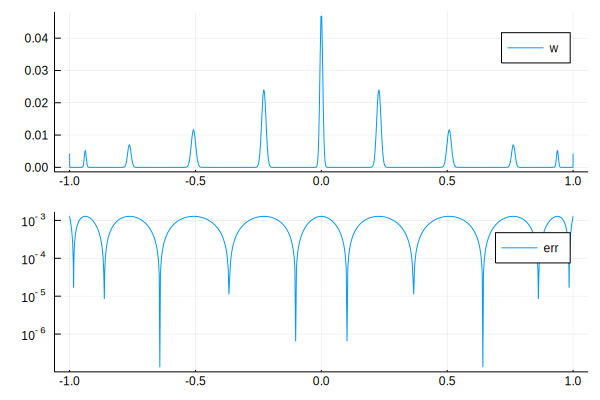

In [77]:
using Plots
P1 = plot(X, w, label = "w")
P2 = plot(X, abs.(y - A * x), label = "err", yaxis = (:log,))
plot(P1, P2, layout = grid(2,1))